In [3]:
#关闭警告信息
import warnings
warnings.filterwarnings('ignore')

系统检测：测试GPU可用性、查看CPU核心数

In [4]:
#查看CPU核心数
import os
print('CPU核心数:',os.cpu_count())

CPU核心数: 8


In [ ]:
#测试GPU可用性
import tensorflow as tf
print('GPU可用性:',tf.test.is_gpu_available())
print('可用GPU名称:',tf.test.gpu_device_name())

GPU可用性: True
可用GPU名称: /device:GPU:0

读取数据，并进行必要的数据预处理。

In [6]:
#读取数据
import pandas as pd
Data=pd.read_csv('/mnt/workspace/DNA methylation data/RA DNA methylation/RA_Methylation_Feature.csv')
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425 entries, 0 to 6424
Data columns (total 67 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6425 non-null   int64  
 1   cg00455876           6425 non-null   float64
 2   cg05544622           6425 non-null   float64
 3   cg00423014           6425 non-null   float64
 4   cg00478198           6425 non-null   float64
 5   cg00776430           6425 non-null   float64
 6   cg01938887           6425 non-null   float64
 7   cg02714462           6425 non-null   float64
 8   cg02896361           6425 non-null   float64
 9   cg02971902           6425 non-null   float64
 10  cg03601619           6425 non-null   float64
 11  cg04029664           6425 non-null   float64
 12  cg04302300           6425 non-null   float64
 13  cg04699313           6425 non-null   float64
 14  cg05257372           6425 non-null   float64
 15  cg05443523           6425 non-null   f

In [7]:
#查看空缺数据
Data.isnull().sum().sum()

0

Counter({'control': 6266, 'rheumatoid arthritis': 159})


<Axes: >

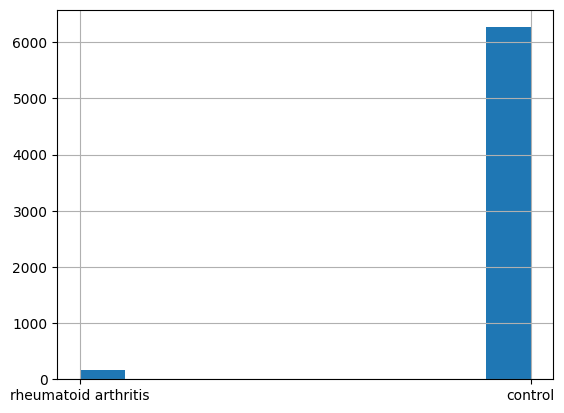

In [8]:
#查看疾病分布
from collections import Counter
print(Counter(Data['disease']))
Data['disease'].hist()

Counter({'F': 3430, 'M': 2995})


<Axes: >

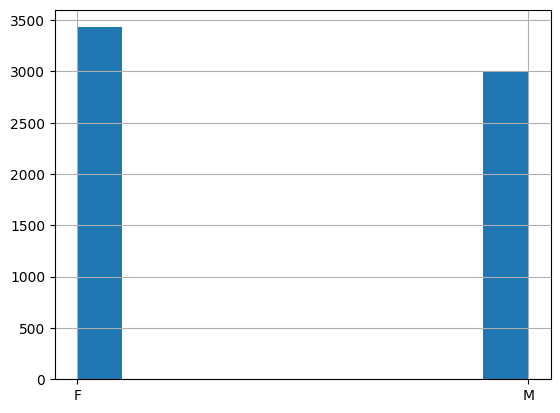

In [9]:
#查看性别数据分布
print(Counter(Data['gender']))
Data['gender'].hist()

In [10]:
#提取数据
DLRunData=Data.iloc[:,1:-6]
#数据缩放和标准化
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler,MinMaxScaler
FeatureNames=DLRunData.columns    #保存变量名
Standard=StandardScaler()    #标准化数据
StandardData=Standard.fit_transform(DLRunData)
MinMax=MinMaxScaler(feature_range=(0,1))    #缩放数据
MinMaxData=MinMax.fit_transform(StandardData)
MLRunData=DataFrame(MinMaxData)
MLRunData.columns=FeatureNames
MLRunData.shape

(6425, 60)

In [11]:
RunData=pd.concat([MLRunData,Data.loc[:,['GenderEncoder','gender','disease','DiseaseEncoder']]],axis=1)
RunData.shape

(6425, 64)

In [12]:
#分离RA数据和正常患者数据
RAData=RunData.loc[RunData.loc[:,'disease']=='rheumatoid arthritis',:]
RAData.shape

(159, 64)

In [13]:
#提取与类风关相同数量的正常患者数据
ContralData=RunData.loc[RunData.loc[:,'disease']=='control',:]
ContralData.shape

(6266, 64)

In [14]:
#分离DataFrame数据
SampleData=ContralData.sample(frac=1,replace=False,axis=0,random_state=2025).reset_index(drop=True)    #随机排列数据
DNNContralData=SampleData.iloc[:159,:]    #提取用于训练的数据
DNNContralData.shape

(159, 64)

In [15]:
#拼接用于训练DNN的数据：正常组和RA数据各159组
DNNData=pd.concat([RAData,DNNContralData],axis=0)
DNNData.shape

(318, 64)

In [16]:
#提取用于训练编-解码器的数据
EDData=SampleData.iloc[159:,:]
EDData.shape

(6107, 64)

加载模型并进行测试.

In [ ]:
#加载模型
from tensorflow import keras
Encoder_Dncoder=keras.models.load_model('/mnt/workspace/TestAnalysis Module/AutoEncoder_Dncoder.h5')
AutoEncoder=keras.models.load_model('/mnt/workspace/TestAnalysis Module/AutoEncoder.h5')

In [18]:
#构建数据
EDRunData=EDData.iloc[:,:-4]
EDRunData.shape

(6107, 60)

In [19]:
#数据切分和构建数据输入流
ENTrain=tf.data.Dataset.from_tensor_slices((EDRunData.iloc[:4000,:],EDRunData.iloc[:4000,:])).repeat(50)    #训练集
ENTrain=ENTrain.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
ENValid=tf.data.Dataset.from_tensor_slices((EDRunData.iloc[4000:5000,:],EDRunData.iloc[4000:5000,:])).repeat(50)    #验证集
ENValid=ENValid.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
ENTest=tf.data.Dataset.from_tensor_slices((EDRunData.iloc[5000:,:],EDRunData.iloc[5000:,:])).repeat(50)    #测试集
ENTest=ENTest.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
#评估AME
Encoder_Dncoder.evaluate(ENTest)

56/56 [==============================] - 2s 3ms/step - loss: 0.0243 - mae: 0.0243


[0.024308105930685997, 0.024308105930685997]

Encoder-Dncoder模型MAE为:0.024308105930685997

1/1 [==============================] - 0s 293ms/step
预测数据与真实数据R2= 0.924752229558242
预测数据与真实数据残差(均值)= -0.000330230333274154


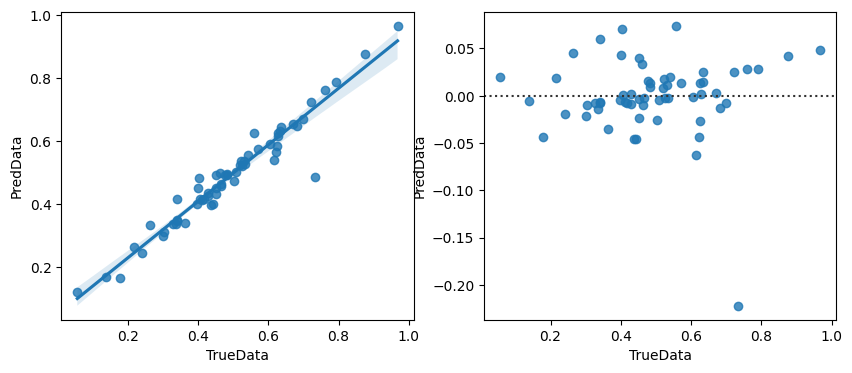

In [22]:
#查看数据回归曲线
import numpy as np
from sklearn.metrics import r2_score
import seaborn as sns
from pandas import DataFrame
def RegressionCurve(Model,TrueData):
    Predict=Model.predict(TrueData)    #预测值
    R2Score=r2_score(Predict[0],TrueData[0])
    RegData=DataFrame()
    RegData['TrueData']=list(TrueData[0])
    RegData['PredData']=list(Predict[0])
    print('预测数据与真实数据R2=',R2Score)
    figure=plt.figure(figsize=(10,4))
    ax1=figure.add_subplot(1,2,1)
    sns.regplot(data=RegData,x='TrueData',y='PredData',ci=95)
    ResidValue=RegData['TrueData']-RegData['PredData']
    print('预测数据与真实数据残差(均值)=',ResidValue.mean())
    ax1=figure.add_subplot(1,2,2)
    sns.residplot(data=RegData,x='TrueData',y='PredData')
RegressionCurve(Model=Encoder_Dncoder,TrueData=np.array(EDRunData.iloc[0,:]).reshape(1,-1))

查看正常患者和RA患者的R2值。

In [23]:
#提取RA和正常人数据
RA=DNNData.loc[DNNData.loc[:,'disease']=='rheumatoid arthritis',:]
RA=RA.iloc[:,:-4]
Normal=DNNData.loc[DNNData.loc[:,'disease']=='control',:]
Normal=Normal.iloc[:,:-4]

1/1 [==============================] - 0s 14ms/step
预测数据与真实数据R2= 0.8746036870061717
预测数据与真实数据残差(均值)= -0.0023920254234124473


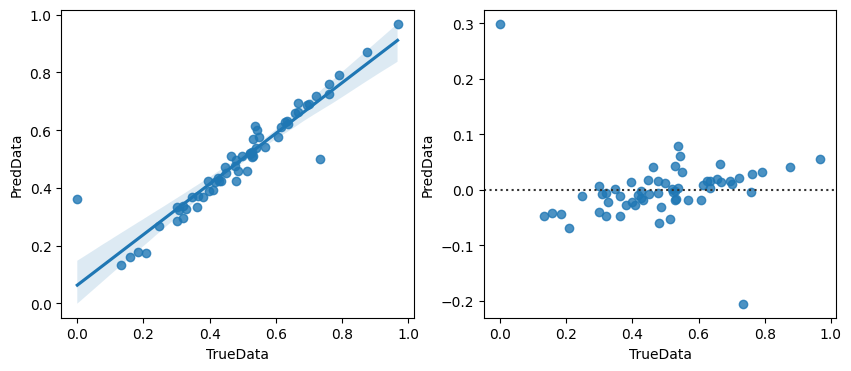

In [24]:
#正常患者
RegressionCurve(Model=Encoder_Dncoder,TrueData=np.array(Normal.iloc[0,:]).reshape(1,-1))

1/1 [==============================] - 0s 13ms/step
预测数据与真实数据R2= 0.9884341214117878
预测数据与真实数据残差(均值)= -0.000894589324728647


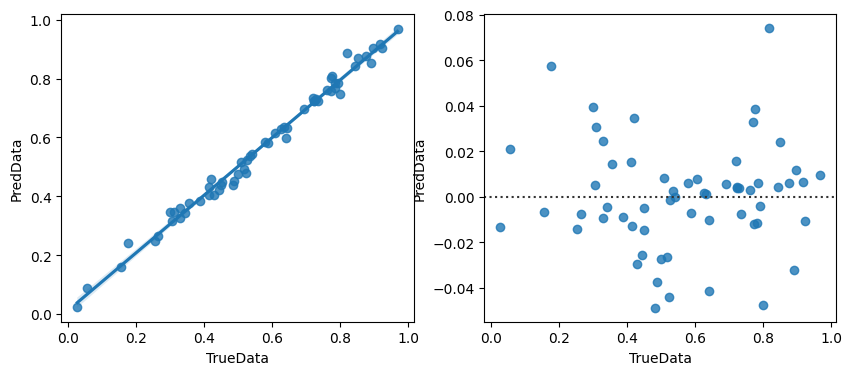

In [25]:
#RA患者
RegressionCurve(Model=Encoder_Dncoder,TrueData=np.array(RA.iloc[0,:]).reshape(1,-1))

绘制自编码器编码正常人和RA患者的数据。

1/1 [==============================] - 0s 13ms/step


<Axes: >

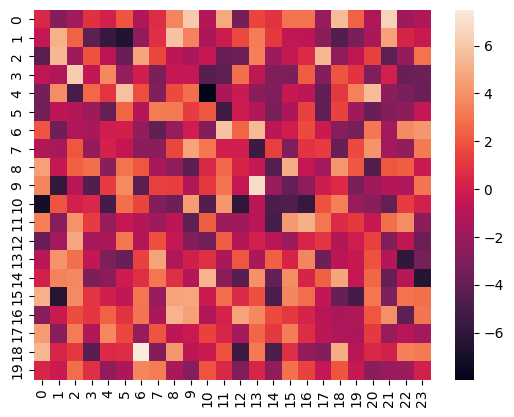

In [72]:
#绘制正常人患者自编码器后高维数据热力图
import seaborn as sns
Normal_Encoder=AutoEncoder.predict(np.array(Normal.iloc[0,:]).reshape(1,-1))
sns.heatmap(Normal_Encoder.reshape((20,24)))

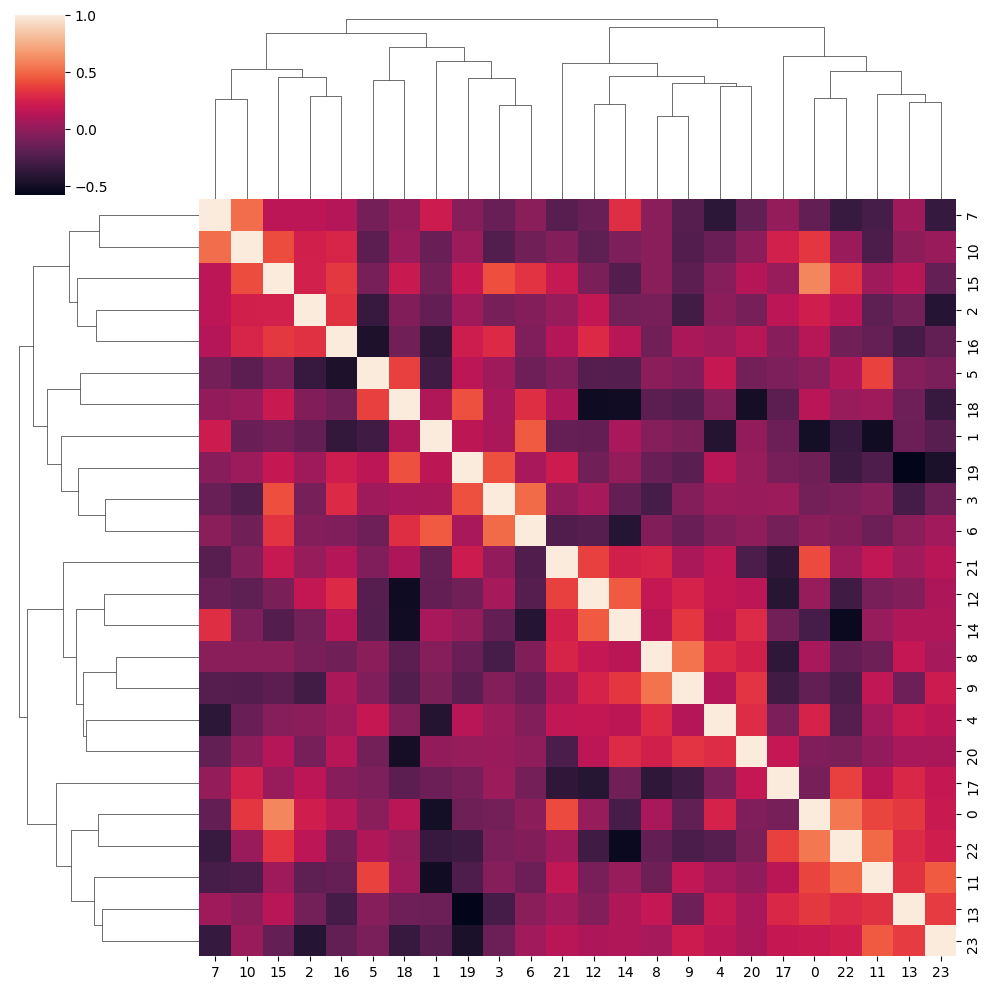

In [74]:
#计算高维数据间的相关性
NormalEncoder_corr=DataFrame(Normal_Encoder.reshape((20,24))).corr(method='spearman')
sns.clustermap(NormalEncoder_corr)

1/1 [==============================] - 0s 13ms/step


<Axes: >

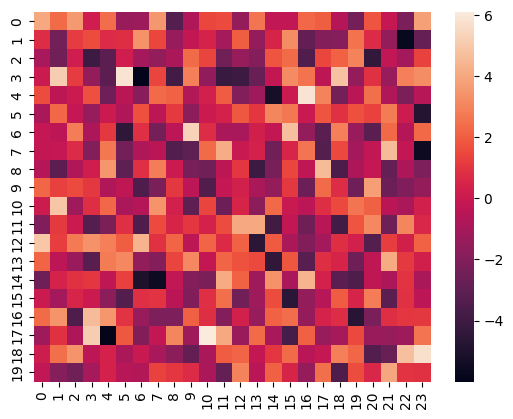

In [71]:
#绘制RA患者自编码器后高维数据热力图
import seaborn as sns
RA_Encoder=AutoEncoder.predict(np.array(RA.iloc[0,:]).reshape(1,-1))
sns.heatmap(RA_Encoder.reshape((20,24)))

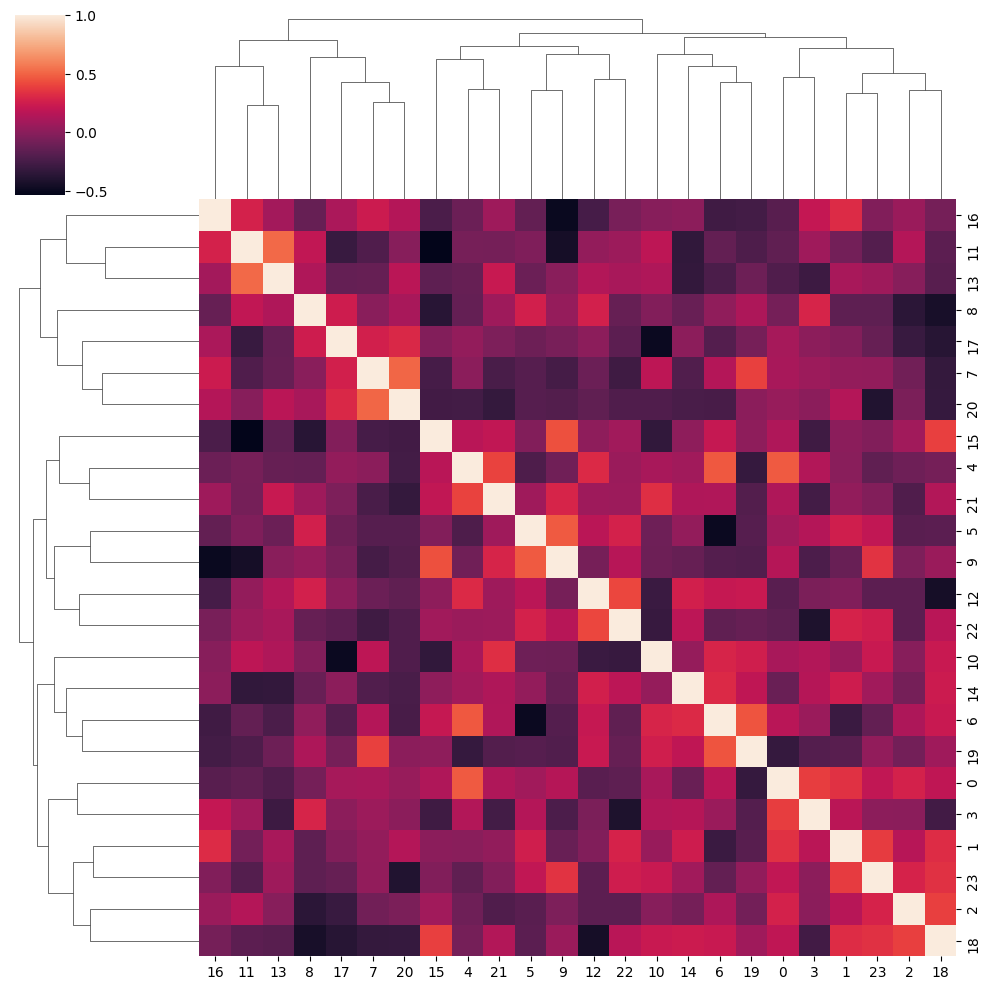

In [75]:
#计算高维数据间的相关性
RAEncoder_corr=DataFrame(RA_Encoder.reshape((20,24))).corr(method='spearman')
sns.clustermap(RAEncoder_corr)

使用差异分析比较正常人和RA患者经过AutoEncoder模型编码后的差异性.

In [61]:
#以是否发生类风湿性关节炎分组进行差异分析
#使用Mann-Whitney U和Kruskal-Wallis H进行差异分析
from scipy.stats import mannwhitneyu,kruskal
Diff_name,Mann_W_stats,Mann_W_pvalue=[],[],[]
KW_Stats,KW_Pvalue=[],[]
RA_Stats=DataFrame(RA_Encoder.reshape((20,24)))
Normal_stats=DataFrame(Normal_Encoder.reshape((20,24)))
for name in np.arange(24):
    mann_stats,mann_pvalue=mannwhitneyu(RA_Stats.iloc[:,name],Normal_stats.iloc[:,name],alternative='two-sided')
    Diff_name.append(name)
    Mann_W_stats.append(mann_stats)
    Mann_W_pvalue.append(mann_pvalue)
    kw_stats,kw_pvalue=kruskal(RA_Stats.iloc[:,name],Normal_stats.iloc[:,name])
    KW_Stats.append(kw_stats)
    KW_Pvalue.append(kw_pvalue)
DiffResult=DataFrame()
DiffResult['Feature']=Diff_name
DiffResult['Mann-Whitney U Stats']=Mann_W_stats
DiffResult['Mann-Whitney U Pvalue']=Mann_W_pvalue
DiffResult['Kruskal-Wallis H Stat']=KW_Stats
DiffResult['Kruskal-Wallis P Pvalue']=KW_Pvalue
DiffResult=DiffResult.sort_values('Mann-Whitney U Pvalue',ascending=True)
DiffResult

,Feature,Mann-Whitney U Stats,Mann-Whitney U Pvalue,Kruskal-Wallis H Stat,Kruskal-Wallis P Pvalue
13,13,122.0,0.036048,4.451707,0.034866
14,14,278.0,0.036048,4.451707,0.034866
17,17,256.0,0.133283,2.294634,0.129822
12,12,255.0,0.140420,2.213415,0.136816
16,16,146.0,0.147847,2.133659,0.144096
2,2,149.0,0.171930,1.903171,0.167724
6,6,153.0,0.208454,1.616341,0.203603
4,4,242.0,0.261616,1.290732,0.255913
1,1,242.0,0.261616,1.290732,0.255913
21,21,242.0,0.261616,1.290732,0.255913


In [29]:
#输出差异分析结果
DiffResult.to_excel('/mnt/workspace/TestAnalysis Module/DiffResult_Encoder.xlsx','UTF-8')

In [62]:
#绘制高维数据下的特征散点图
ScatterData=DataFrame()
ScatterData['Normal Feature13']=Normal_stats.iloc[:,13]
ScatterData['Normal Feature14']=Normal_stats.iloc[:,14]
ScatterData['RA Feature13']=RA_Stats.iloc[:,13]
ScatterData['RA Feature14']=RA_Stats.iloc[:,14]

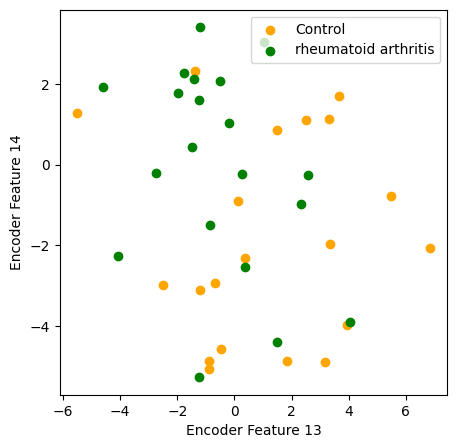

In [63]:
import matplotlib.pyplot as plt
figure=plt.figure(figsize=(5,5))
ax1=figure.add_subplot(1,1,1)
ax1.scatter(x=ScatterData['Normal Feature13'],y=ScatterData['Normal Feature14'],color='orange',label='Control')
ax1.scatter(x=ScatterData['RA Feature13'],y=ScatterData['RA Feature14'],color='green',label='rheumatoid arthritis')
ax1.set_xlabel('Encoder Feature 13')
ax1.set_ylabel('Encoder Feature 14')
plt.legend()
plt.show()

In [64]:
#使用Mann-Whitney U和Kruskal-Wallis H进行差异分析
from scipy.stats import mannwhitneyu,kruskal
Diff_name,Mann_W_stats,Mann_W_pvalue=[],[],[]
KW_Stats,KW_Pvalue=[],[]
RA_StatsT=DataFrame(RA_Encoder.reshape((20,24)).T)
Normal_statsT=DataFrame(Normal_Encoder.reshape((20,24)).T)
for name in np.arange(20):
    mann_stats,mann_pvalue=mannwhitneyu(RA_StatsT.iloc[:,name],Normal_statsT.iloc[:,name],alternative='two-sided')
    Diff_name.append(name)
    Mann_W_stats.append(mann_stats)
    Mann_W_pvalue.append(mann_pvalue)
    kw_stats,kw_pvalue=kruskal(RA_StatsT.iloc[:,name],Normal_statsT.iloc[:,name])
    KW_Stats.append(kw_stats)
    KW_Pvalue.append(kw_pvalue)
DiffResultT=DataFrame()
DiffResultT['Feature']=Diff_name
DiffResultT['Mann-Whitney U Stats']=Mann_W_stats
DiffResultT['Mann-Whitney U Pvalue']=Mann_W_pvalue
DiffResultT['Kruskal-Wallis H Stat']=KW_Stats
DiffResultT['Kruskal-Wallis P Pvalue']=KW_Pvalue
DiffResultT=DiffResultT.sort_values('Mann-Whitney U Pvalue',ascending=True)
DiffResultT

,Feature,Mann-Whitney U Stats,Mann-Whitney U Pvalue,Kruskal-Wallis H Stat,Kruskal-Wallis P Pvalue
12,12,414.0,0.009660,6.750000,0.009375
5,5,404.0,0.017239,5.721088,0.016762
10,10,371.0,0.088920,2.928997,0.087002
15,15,208.0,0.101159,2.721088,0.099030
8,8,218.0,0.151839,2.083333,0.148915
16,16,232.0,0.252462,1.333333,0.248213
3,3,343.0,0.261110,1.286139,0.256761
4,4,322.0,0.489717,0.491497,0.483260
13,13,320.0,0.516003,0.435374,0.509364
14,14,257.0,0.529415,0.408588,0.522687


In [65]:
#绘制高维数据下的特征散点图
ScatterDataT=DataFrame()
ScatterDataT['Normal Feature12']=Normal_statsT.iloc[:,12]
ScatterDataT['Normal Feature5']=Normal_statsT.iloc[:,5]
ScatterDataT['RA Feature12']=RA_StatsT.iloc[:,12]
ScatterDataT['RA Feature5']=RA_StatsT.iloc[:,5]

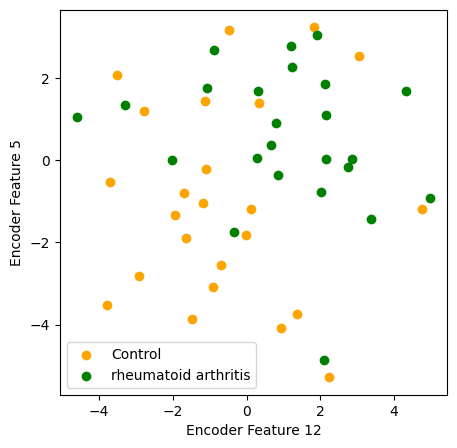

In [66]:
import matplotlib.pyplot as plt
figure=plt.figure(figsize=(5,5))
ax1=figure.add_subplot(1,1,1)
ax1.scatter(x=ScatterDataT['Normal Feature12'],y=ScatterDataT['Normal Feature5'],color='orange',label='Control')
ax1.scatter(x=ScatterDataT['RA Feature12'],y=ScatterDataT['RA Feature5'],color='green',label='rheumatoid arthritis')
ax1.set_xlabel('Encoder Feature 12')
ax1.set_ylabel('Encoder Feature 5')
plt.legend()
plt.show()

In [67]:
#输出差异分析结果
DiffResultT.to_excel('/mnt/workspace/TestAnalysis Module/DiffResult_EncoderT.xlsx','UTF-8')

加载自定义组件

In [34]:
#定义位置编码
import numpy as np
class PositionalEncoder(keras.layers.Layer):
    def __init__(self,max_step,max_dims,dtype=tf.float32,**kwargs):
        super().__init__(dtype=dtype,**kwargs)
        self.max_step=max_step
        self.max_dims=max_dims
        if self.max_step%2==1:
            self.max_dims=self.max_dims+1
        p,i=np.meshgrid(np.arange(self.max_step),np.arange(self.max_dims//2))    #生成坐标矩阵
        pos_emb=np.empty((1,self.max_step,self.max_dims))
        pos_emb[0,:,::2]=np.sin(p/10000**(2*i/self.max_dims)).T
        pos_emb[0,:,1::2]=np.cos(p/10000**(2*i/self.max_dims)).T
        self.positial_embedding=tf.constant(pos_emb.astype(self.dtype))
    def call(self,Input):
        shape=tf.shape(Input)
        return Input+self.positial_embedding[:shape[-2],:shape[-1]]
    def compute_output_shape(self):    #规范输出维度
        return tf.TensorShape([20,24])
    def get_config(self):
        Basconfig = super().get_config()
        return {**Basconfig,'max_step':self.max_step,'max_dims':self.max_dims}

In [37]:
#引入自注意力机制-基于ResNet模块
from tensorflow import keras    
class ResformerEncoder(keras.layers.Layer):
    def __init__(self,heads,key_dim,input_dim,Wdim,**kwargs):
        super().__init__(**kwargs)
        self.heads=heads    #注意力头数
        self.key_d=key_dim    #Key维度
        self.input_dim=input_dim    #输入数据维度
        self.Wdim=Wdim    #矩阵维度
        self.Wq=keras.layers.Dense(input_dim=self.input_dim,units=self.Wdim,activation=None,use_bias=False)    #Q矩阵
        self.Wk=keras.layers.Dense(input_dim=self.input_dim,units=self.Wdim,activation=None,use_bias=False)    #K矩阵
        self.Wv=keras.layers.Dense(input_dim=self.input_dim,units=self.Wdim,activation=None,use_bias=False)    #V矩阵
        self.Multi_Head_Attention=keras.layers.MultiHeadAttention(num_heads=self.heads,key_dim=self.key_d)    #自注意力
        self.LayerNormaltion=keras.layers.LayerNormalization()    #层归一化
        self.LinearLayer=keras.layers.Dense(input_dim=self.input_dim,units=self.Wdim,activation=None,use_bias=False)    #线性层
        self.Leaky_Relu=keras.layers.LeakyReLU(alpha=0.01)    #使用LeakyRelu激活函数
        self.LinearActivation=keras.layers.Dense(input_dim=self.input_dim,units=self.Wdim,activation='selu',
                                                 kernel_initializer=None,use_bias=False)    #使用SELU激活函数的线性层
        self.AddLayer=keras.layers.Add()    #相加层
    def call(self,Input):    #前向计算
        Q=self.Wq(Input)    #Q矩阵
        K=self.Wk(Input)    #K矩阵
        V=self.Wv(Input)    #Value矩阵
        MSA=self.Multi_Head_Attention(query=Q,value=K,key=V)    #计算Multi-Head-attention
        ResActivation=self.LinearActivation(Input)    #基于ResNet模块
        ResLinear=self.LinearLayer(ResActivation)
        ResAdd=self.AddLayer([ResLinear,Input])
        ResLeakyRelu=self.Leaky_Relu(ResAdd)
        ResNet=self.AddLayer([MSA,ResLeakyRelu])    #残差连接
        ResNormaltion=self.LayerNormaltion(ResNet)    #层归一化
        LinearOutput=self.LinearLayer(ResNormaltion)
        LinearActiontion=self.LinearActivation(LinearOutput)
        LeakyRelu=self.Leaky_Relu(LinearActiontion)
        ResNet2=self.AddLayer([LeakyRelu,ResNormaltion])
        Res2Normaltion=self.LayerNormaltion(ResNet2)    #层归一化
        return Res2Normaltion
    def compute_output_shape(self):    #规范输出维度
        return tf.TensorShape([self.input_dim,self.Wdim])
    def get_config(self):
        Base_config=super().get_config()
        return {**Base_config,'heads':self.heads,'key_dim':self.key_d,'input_dim':self.input_dim,'Wdim':self.Wdim}

In [38]:
#加载LibraFormer模型
with custom_object_scope({'PositionalEncoder': PositionalEncoder,'ResformerEncoder':ResformerEncoder}):
    LibraFormer=keras.models.load_model('/mnt/workspace/TestAnalysis Module/LibraFormer.h5')

配置测试ResFormer模型的数据.

In [39]:
#构建DNN数据
from sklearn.model_selection import train_test_split
TrainRAData,LiteRAData,TrainRALabel,LiteRALabel=train_test_split(DNNData.iloc[:,:-4],DNNData.loc[:,'DiseaseEncoder'],train_size=0.6,random_state=2025)
ValidRAData=LiteRAData.iloc[:60,:]    #验证数据集
ValidRALabel=LiteRALabel[:60]
TestRAData=LiteRAData.iloc[60:,:]    #测试数据集
TestRALabel=LiteRALabel[60:]

In [40]:
#构建数据输入流
TrainRA=tf.data.Dataset.from_tensor_slices((TrainRAData,TrainRALabel)).repeat(100)    #训练集数据流
TrainRA=TrainRA.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
ValidRA=tf.data.Dataset.from_tensor_slices((ValidRAData,ValidRALabel)).repeat(100)    #验证集数据流
ValidRA=ValidRA.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
TestRA=tf.data.Dataset.from_tensor_slices((TestRAData,TestRALabel)).repeat(100)    #测试集数据流
TestRA=TestRA.shuffle(buffer_size=5000,seed=2025).batch(batch_size=1000).prefetch(tf.data.experimental.AUTOTUNE)

In [41]:
#模型评估函数
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
def TestDNN(Model,Data,Label):
    #数据转化
    PredictLabel=[]
    Predict_Proba=Model.predict(Data)
    for proba in Predict_Proba:
        if proba<=0.5:
            PredictLabel.append(0)
        elif proba>0.5:
            PredictLabel.append(1)
    TestPrecision=precision_score(Label,PredictLabel)
    TestRecall=recall_score(Label,PredictLabel)
    TestF1=f1_score(Label,PredictLabel)
    TestAccuracy=accuracy_score(Label,PredictLabel)
    print('模型数据集Precision:{0},Recall:{1},F1_score:{2},Accuracy:{3}'.format(TestPrecision,TestRecall,TestF1,TestAccuracy))
    print('-------------------测试集混淆举证-------------------')
    ConfusionMatrix_result=confusion_matrix(Label,PredictLabel,labels=[0,1])    #计算混淆举证
    Display_ConfusionMatrix=ConfusionMatrixDisplay(ConfusionMatrix_result,display_labels=['control','rheumatoid arthritis'])
    Display_ConfusionMatrix.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format='d', ax=None)
    plt.title('Confusion Matrix')
    plt.show()

2025-01-28 11:40:23.236219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900


6/6 [==============================] - 3s 12ms/step
模型数据集Precision:1.0,Recall:1.0,F1_score:1.0,Accuracy:1.0
-------------------测试集混淆举证-------------------


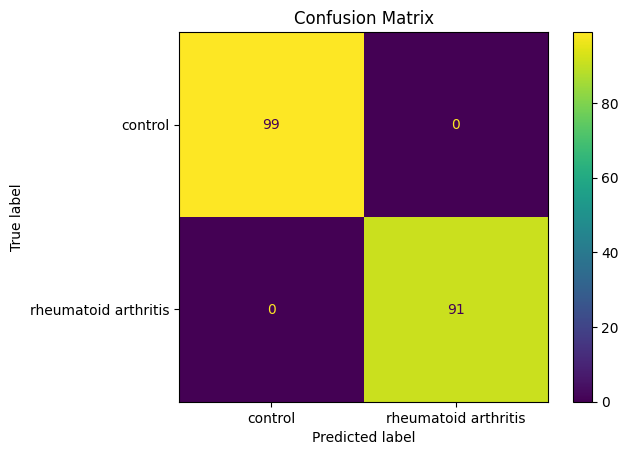

In [42]:
#测试ResFormer模型-训练集
TestDNN(Model=LibraFormer,Data=TrainRAData,Label=TrainRALabel)

2/2 [==============================] - 0s 12ms/step
模型数据集Precision:0.9393939393939394,Recall:0.96875,F1_score:0.9538461538461539,Accuracy:0.95
-------------------测试集混淆举证-------------------


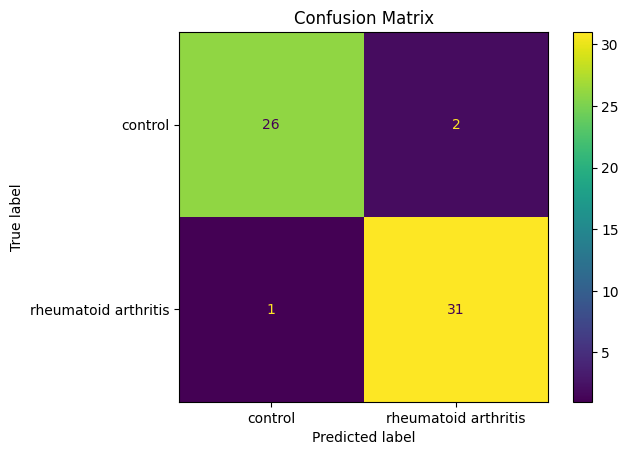

In [43]:
#测试ResFormer模型-验证集
TestDNN(Model=LibraFormer,Data=ValidRAData,Label=ValidRALabel)

3/3 [==============================] - 0s 12ms/step
模型数据集Precision:0.9459459459459459,Recall:0.9722222222222222,F1_score:0.958904109589041,Accuracy:0.9558823529411765
-------------------测试集混淆举证-------------------


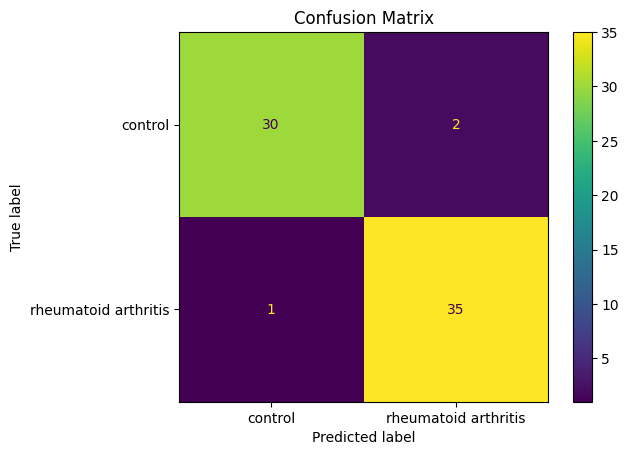

In [44]:
#测试ResFormer模型-测试集
TestDNN(Model=LibraFormer,Data=TestRAData,Label=TestRALabel)

In [45]:
#计算PR曲线
from pandas import DataFrame
from sklearn.metrics import precision_recall_curve,accuracy_score
def PR_Curve(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    predict_score=Model.predict(X_test)[:, 0]    #获取概率值
    #数据转化
    PredictLabel=[]
    for proba in predict_score:
        if proba<=0.5:
            PredictLabel.append(0)
        elif proba>0.5:
            PredictLabel.append(1)
    accuracy=accuracy_score(y_test,PredictLabel)
    precision, recall, thresholds = precision_recall_curve(y_test, predict_score)    #计算PR曲线
    PR=DataFrame()    #将PR曲线数据合并到DataFrame
    #PR['thresholds']=thresholds
    PR['recall']=recall
    PR['precision']=precision
    return PR,accuracy

In [46]:
#计算LibraFormer模型PR曲线
LibraFormer_PR,LibraFormer_Accuracy=PR_Curve(Model=LibraFormer,Data=TestRAData,Label=TestRALabel)

1/1 [==============================] - 0s 25ms/step


In [47]:
#读取测试机器学习模型PR曲线数据
ReLogistic_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/Logistic_PR.xlsx','UTF-8')
ReLogistic_PR=ReLogistic_PR.iloc[:,1:]
ReSVM_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReSVM_PR.xlsx','UTF-8')
ReSVM_PR=ReSVM_PR.iloc[:,1:]
ReDTC_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReDTC_PR.xlsx','UTF-8')
ReDTC_PR=ReDTC_PR.iloc[:,1:]
ReRondomForest_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReRondomForest_PR.xlsx','UTF-8')
ReRondomForest_PR=ReRondomForest_PR.iloc[:,1:]
ReXGBoost_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReXGBoost_PR.xlsx','UTF-8')
ReXGBoost_PR=ReXGBoost_PR.iloc[:,1:]
ReLightGBM_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReLightGBM_PR.xlsx','UTF-8')
ReLightGBM_PR=ReLightGBM_PR.iloc[:,1:]
ReCatBoost_PR=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/ReCatBoost_PR.xlsx','UTF-8')
ReCatBoost_PR=ReCatBoost_PR.iloc[:,1:]

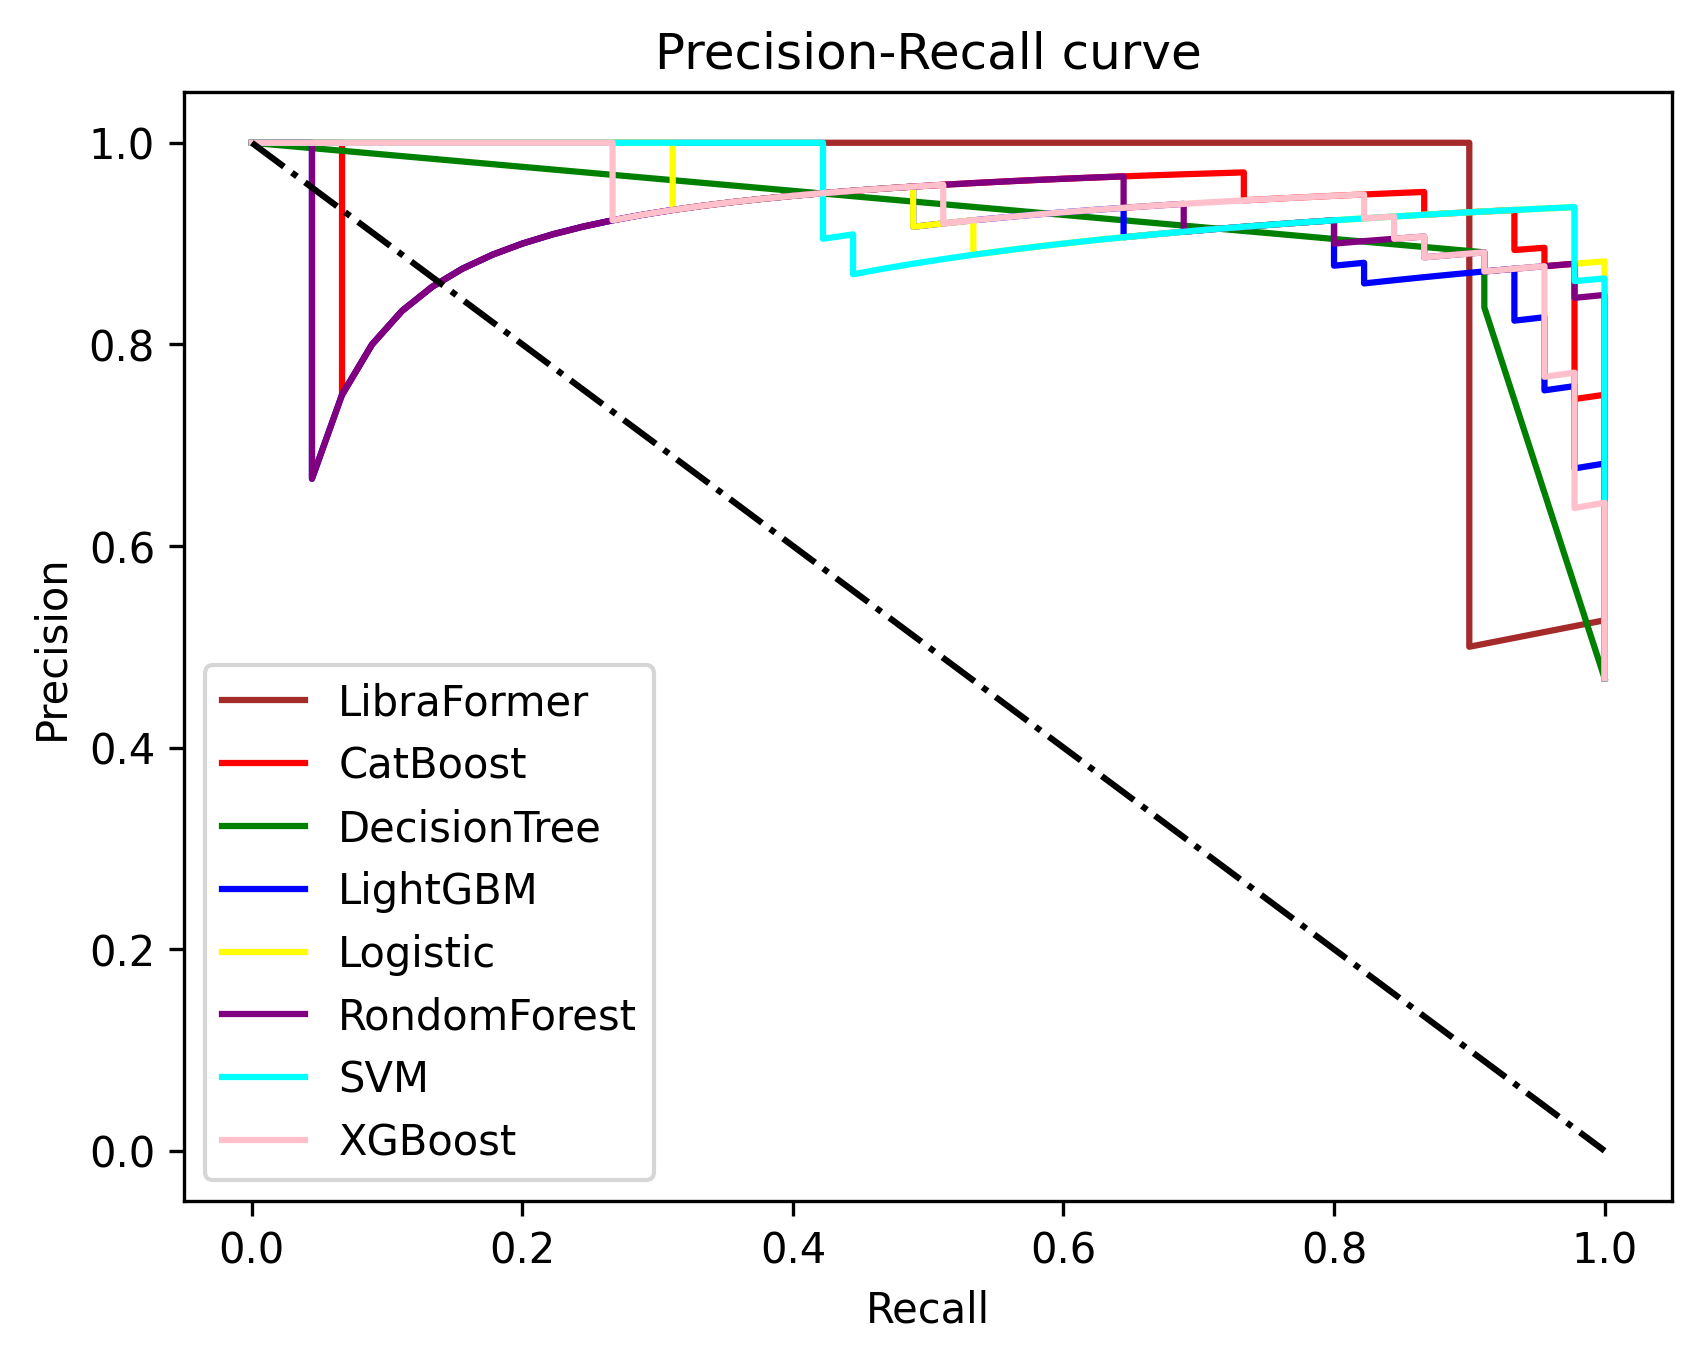

In [48]:
#绘制PR曲线
import matplotlib.pyplot as plt
PR_curve=plt.figure(dpi=300)
PR_ax=PR_curve.add_subplot(111)
PR_ax.set_title('Precision-Recall curve')
PR_ax.plot(LibraFormer_PR['recall'], LibraFormer_PR['precision'],color='brown',label='LibraFormer')
PR_ax.plot(ReCatBoost_PR['recall'], ReCatBoost_PR['precision'],color='red',label='CatBoost')
PR_ax.plot(ReDTC_PR['recall'], ReDTC_PR['precision'],color='green',label='DecisionTree')
PR_ax.plot(ReLightGBM_PR['recall'], ReLightGBM_PR['precision'],color='blue',label='LightGBM')
PR_ax.plot(ReLogistic_PR['recall'], ReLogistic_PR['precision'],color='yellow',label='Logistic')
PR_ax.plot(ReRondomForest_PR['recall'], ReRondomForest_PR['precision'],color='purple',label='RondomForest')
PR_ax.plot(ReSVM_PR['recall'], ReSVM_PR['precision'],color='cyan',label='SVM')
PR_ax.plot(ReXGBoost_PR['recall'], ReXGBoost_PR['precision'],color='pink',label='XGBoost')
PR_ax.plot([0,1],[1,0],linestyle='-.',color='black')
PR_ax.set_xlabel('Recall')  
PR_ax.set_ylabel('Precision')    
plt.legend(loc="best")  
plt.show()

In [49]:
#计算LibraFormer模型ROC曲线
from sklearn.metrics import roc_curve, auc
def ROC_Curve(Model,Data,Label):
    X_train,X_test,y_train,y_test=train_test_split(Data,Label,train_size=0.7,random_state=2025)    #划分数据集
    predict_score=Model.predict(X_test)[:, 0]    #获取概率值
    fpr, tpr, thresholds = roc_curve(y_test, predict_score)
    roc_auc = auc(fpr, tpr)    #计算AUC
    ROC=DataFrame()    #将PR曲线数据合并到DataFrame
    #ROC['thresholds']=thresholds
    ROC['tpr']=tpr
    ROC['fpr']=fpr
    return ROC,roc_auc

In [50]:
LibraFormer_ROC,LibraFormer_AUC=ROC_Curve(Model=LibraFormer,Data=TestRAData,Label=TestRALabel)    #计算LibraFormer模型ROC曲线

1/1 [==============================] - 0s 25ms/step


In [51]:
LibraFormer.evaluate(TestRA)

7/7 [==============================] - 4s 31ms/step - loss: 2.2737 - auc: 0.9527


[2.2736611366271973, 0.9526908993721008]

LibraFormer模型ROC_AUC为0.9527

In [52]:
#读取测试机器学习模型ROC曲线数据
ReLogistic_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/Logistic_ROC.xlsx','UTF-8')
ReLogistic_ROC=ReLogistic_ROC.iloc[:,1:]
ReSVM_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReSVM_ROC.xlsx','UTF-8')
ReSVM_ROC=ReSVM_ROC.iloc[:,1:]
ReDTC_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReDTC_ROC.xlsx','UTF-8')
ReDTC_ROC=ReDTC_ROC.iloc[:,1:]
ReRondomForest_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReRondomForest_ROC.xlsx','UTF-8')
ReRondomForest_ROC=ReRondomForest_ROC.iloc[:,1:]
ReXGBoost_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReXGBoost_ROC.xlsx','UTF-8')
ReXGBoost_ROC=ReXGBoost_ROC.iloc[:,1:]
ReLightGBM_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReLightGBM_ROC.xlsx','UTF-8')
ReLightGBM_ROC=ReLightGBM_ROC.iloc[:,1:]
ReCatBoost_ROC=pd.read_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/ReCatBoost_ROC.xlsx','UTF-8')
ReCatBoost_ROC=ReCatBoost_ROC.iloc[:,1:]

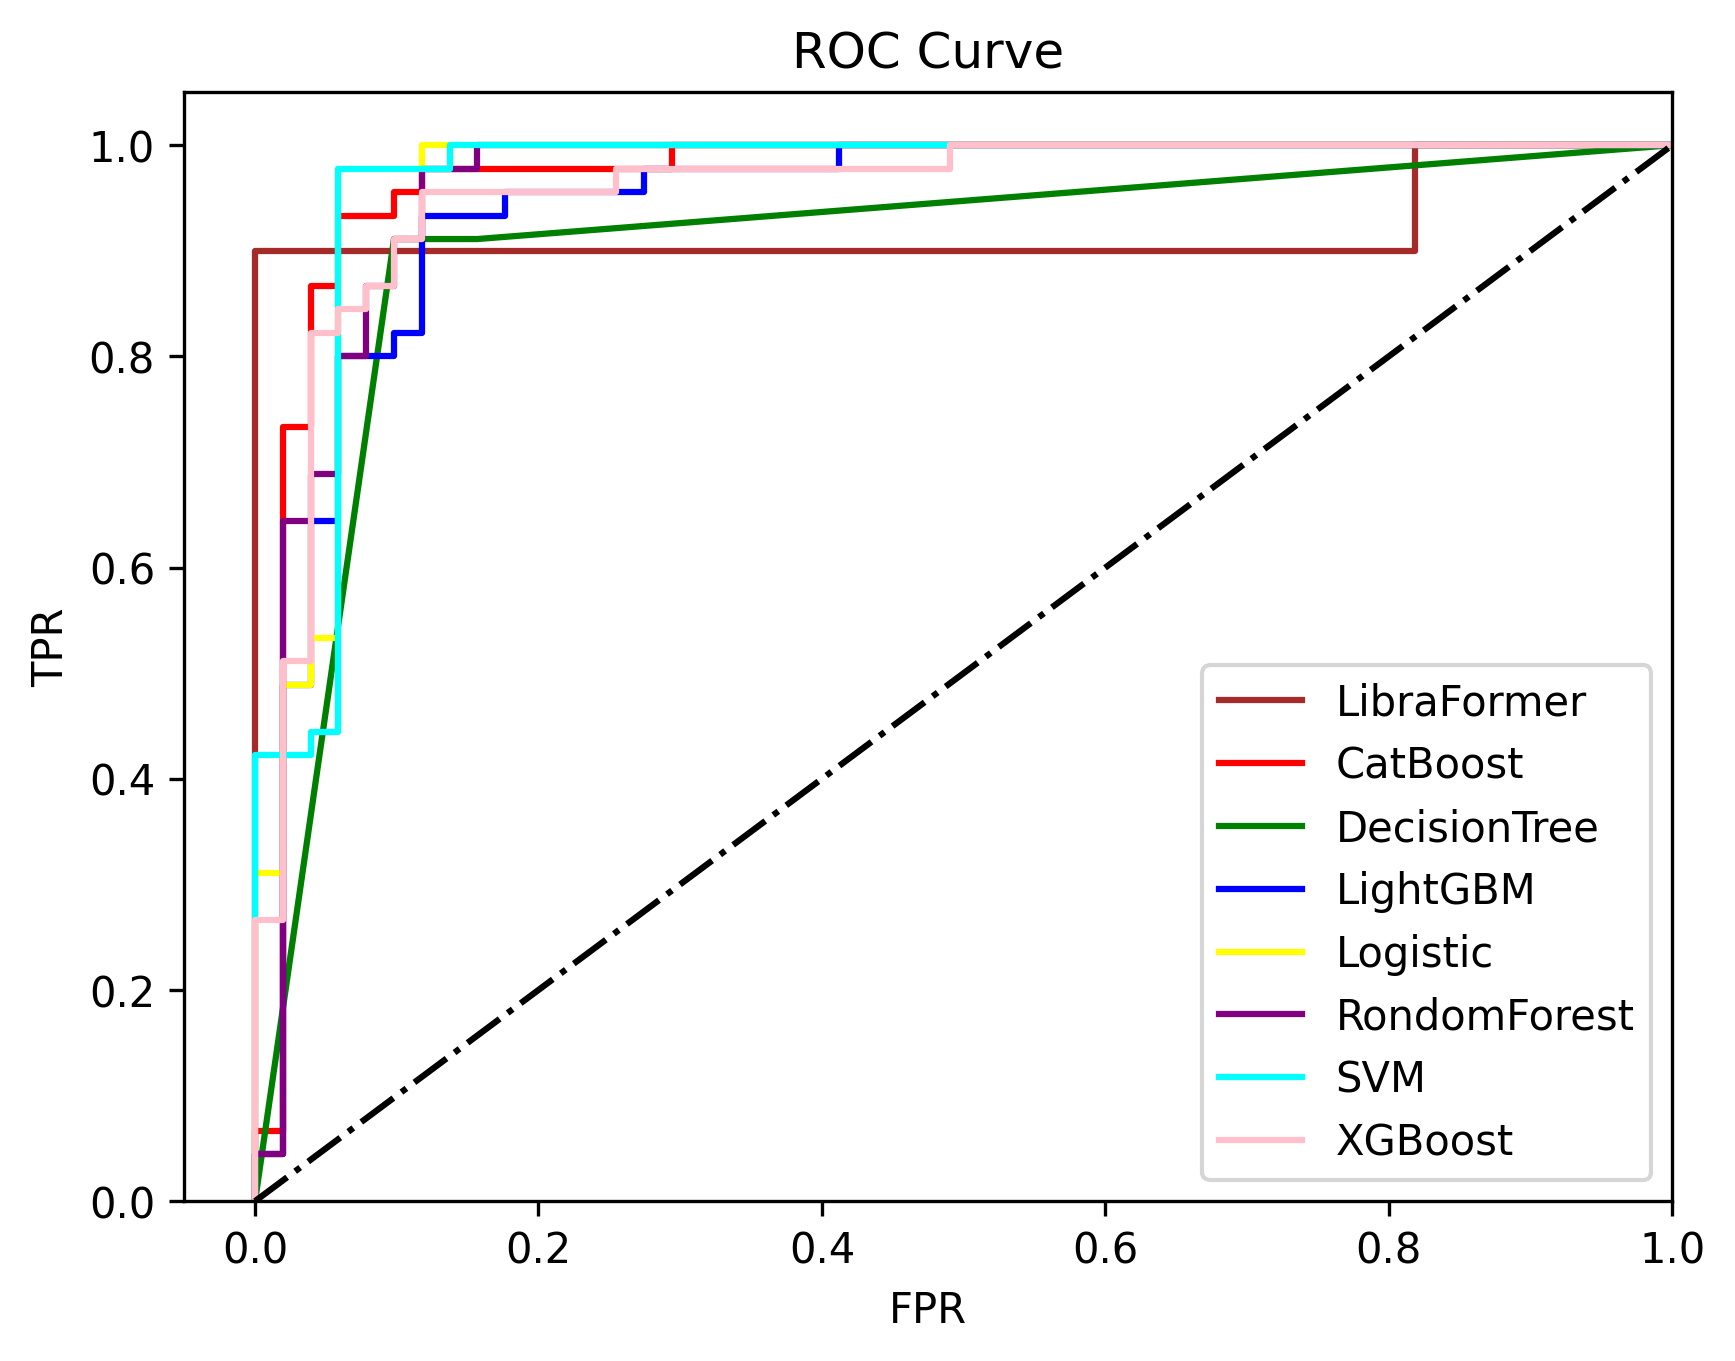

In [53]:
#绘制ROC曲线
import matplotlib.pyplot as plt
ROC_curve=plt.figure(dpi=300)
ROC_ax=ROC_curve.add_subplot(111)
ROC_ax.set_title('ROC Curve')
ROC_ax.plot(LibraFormer_ROC['fpr'], LibraFormer_ROC['tpr'],color='brown',label='LibraFormer')
ROC_ax.plot(ReCatBoost_ROC['fpr'], ReCatBoost_ROC['tpr'],color='red',label='CatBoost')
ROC_ax.plot(ReDTC_ROC['fpr'], ReDTC_ROC['tpr'],color='green',label='DecisionTree')
ROC_ax.plot(ReLightGBM_ROC['fpr'], ReLightGBM_ROC['tpr'],color='blue',label='LightGBM')
ROC_ax.plot(ReLogistic_ROC['fpr'], ReLogistic_ROC['tpr'],color='yellow',label='Logistic')
ROC_ax.plot(ReRondomForest_ROC['fpr'], ReRondomForest_ROC['tpr'],color='purple',label='RondomForest')
ROC_ax.plot(ReSVM_ROC['fpr'], ReSVM_ROC['tpr'],color='cyan',label='SVM')
ROC_ax.plot(ReXGBoost_ROC['fpr'], ReXGBoost_ROC['tpr'],color='pink',label='XGBoost')
ROC_ax.plot([0,1],[0,1],linestyle='-.',color='black')
ROC_ax.set_xlim([-0.05, 1.0])  
ROC_ax.set_ylim([0, 1.05])  
ROC_ax.set_xlabel('FPR')  
ROC_ax.set_ylabel('TPR')    
plt.legend(loc="best")  
plt.show()

In [54]:
#输出PR曲线和ROC曲线数据
LibraFormer_PR.to_excel('/mnt/workspace/Model test Module/Resample Data/ML PR Curve/LibraFormer_PR.xlsx','UTF-8')
LibraFormer_ROC.to_excel('/mnt/workspace/Model test Module/Resample Data/ML ROC Curve/LibraFormer_ROC.xlsx','UTF-8')